<a href="https://colab.research.google.com/github/AryanDineshGour/django-cms-quickstart/blob/main/Toxic%20Comment%20Classifier%20using%20Bidirectional%20LMTS%20NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import classification_report

# WordCloud ke liye extra install
from wordcloud import WordCloud

**Load and preprocess data**

In [ ]:
file_path = "/content/drive/MyDrive/Toxic Comment NLP/train.csv"

# Error handling ke saath data load
try:
    df = pd.read_csv(file_path)
    print("Data load Sucessfully! Total rows:", len(df))
except:
    try:
        df = pd.read_csv(file_path, engine='python', error_bad_lines=False)
        print("Kuch lines mein problem tha, unko skip karke load kiya")
    except Exception as e:
        print("Load nahi ho paya:", e)

Data load Sucessfully! Total rows: 159571


**Exploratory Data Analysis (EDA)**

In [90]:
print("\nBasic Dataset Checking : ")
print("Pehle 5 rows:\n", df.head())
print("\n Columns ke naam: ", df.columns.tolist())
print("\nMissing values ka count:\n", df.isnull().sum())


Basic Dataset Checking : 
Pehle 5 rows:
                  id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  \
0             0        0       0       0              0   
1             0        0       0       0              0   
2             0        0       0       0              0   
3             0        0       0       0              0   
4             0        0       0       0              0   

                                        cleaned_text  
0  explanation why the edits made under my userna...  
1  daw

In [82]:
# Toxic labels ka analysis
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print("\nToxic Labels ka Distribution : ")
print(df[toxic_labels].sum().sort_values(ascending=False))


Toxic Labels ka Distribution : 
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


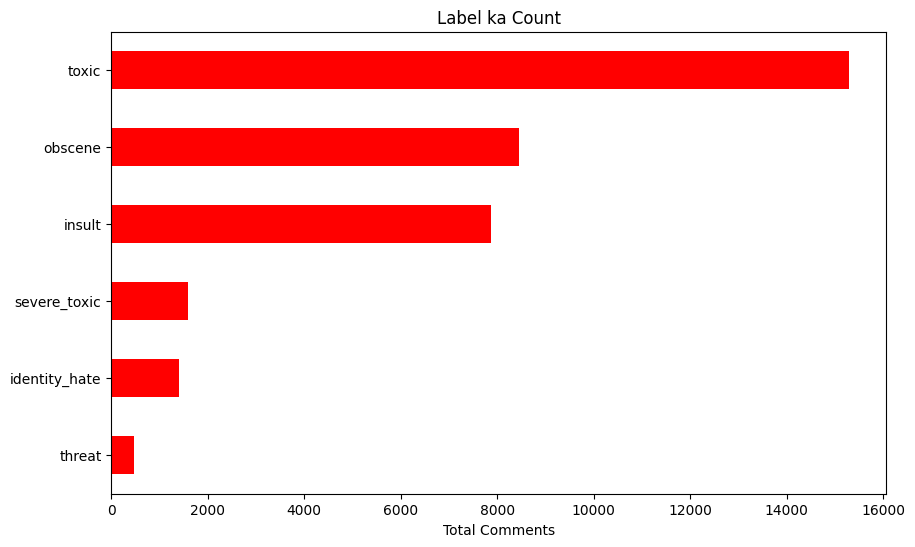

In [ ]:
# Visualization - Labels ka bar plot
plt.figure(figsize=(10,6))
df[toxic_labels].sum().sort_values().plot(kind='barh', color='red')
plt.title("Label ka Count")
plt.xlabel("Total Comments")
plt.show()

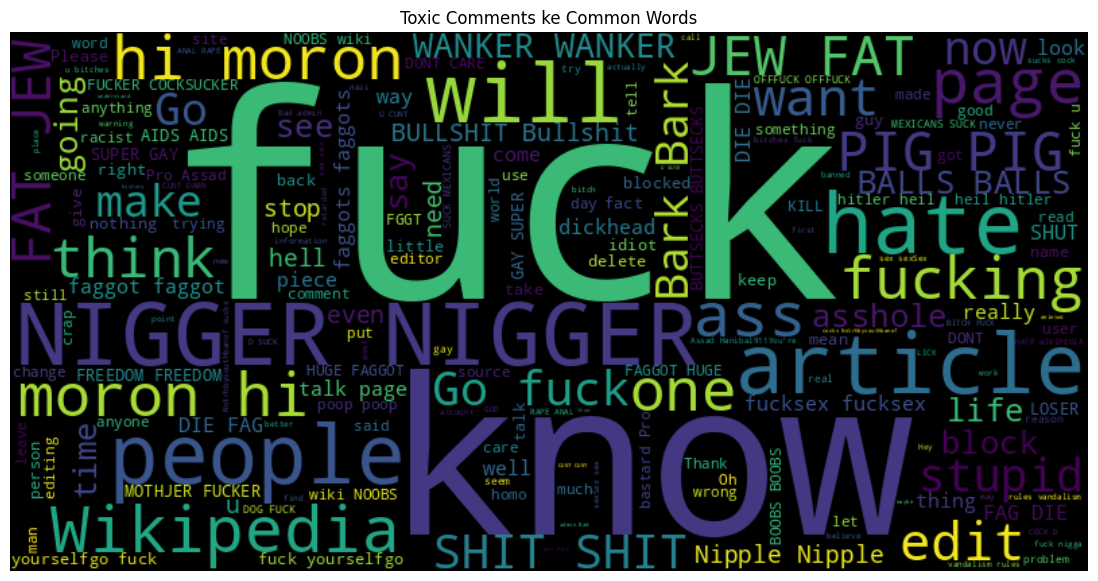

In [ ]:
# WordCloud of toxic comments
toxic_comments = ' '.join(df[df['toxic']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(toxic_comments)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Toxic Comments ke Common Words")
plt.show()

**Text Preprocessing**

In [ ]:
def clean_text(text):
    # Text saaf karne ke liye functions
    text = str(text).lower()  # Sab lowercase kiya
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URLs hata diya
    text = re.sub(r'<.*?>+', '', text)  # HTML tags remove
    text = re.sub(r'[^\w\s]', '', text)  # Punctuation hata diya
    text = re.sub(r'\n', ' ', text)  # Newlines ko space banaya
    text = re.sub(r'\s+', ' ', text).strip()  # Extra spaces hata diya
    return text

df['cleaned_text'] = df['comment_text'].apply(clean_text)
print("\nCleaning ke baad Text Example : ")
print("Original:", df['comment_text'][0])
print("Cleaned:", df['cleaned_text'][0])


Cleaning ke baad Text Example : 
Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Cleaned: explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now892053827


**Train-Test Splil**

In [ ]:
# Labels aur features alag kar diye
X = df['cleaned_text']
y = df[toxic_labels].values

**Tokenization**

In [ ]:
# Tokenization (Text ko numbers mein convert)
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=200)

In [ ]:
# Data ko train-test mein divide kiya , Tokn k baad !
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

**Creating a Model**

In [ ]:
ax_words = 50000  # Tokenizer k num_words k sath match kiya
max_length = 200    # pad_sequences me use kiye hua maxlen

model = Sequential(name="Toxic_Comment_Classifier")

In [ ]:
# 1. Embedding Layer (FIXED)
model.add(Embedding(
    input_dim=ax_words,   # Vocabulary size  <-- Changed 'max_words' to 'ax_words'
    output_dim=128,        # Embedding dimension
    input_shape=(max_length,)  # Input shape explicitly define kiya
))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 2. Bidirectional LSTM Layers
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(32)))  # Last LSTM layer
model.add(Dropout(0.3))

In [ ]:
# 3. Output Layer
model.add(Dense(6, activation='sigmoid'))

In [ ]:
# Model Compile (Same)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Important: Build model manually before summary
model.build(input_shape=(None, max_length))  # Explicit build call kiya

print("\n Correct Model Summary ")
model.summary()


 Correct Model Summary 


Model: "Toxic_Comment_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 128)            │       6,400,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 200, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,540,422 (24.95 MB)

 Trainable params: 6,540,422 (24.95 MB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [ ]:
print("\nModel Training Shuru karte hai")
# Early stopping add karen taaki overfitting na ho
# Importing EarlyStopping from tensorflow.keras.callbacks
from tensorflow.keras.callbacks import EarlyStopping # Importing the missing class
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)


Model Training Shuru karte hai


In [ ]:
# Training parameters
epochs = 10
batch_size = 128

In [ ]:
# Training shuru karo
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
798/798 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.9642 - loss: 0.0393 - val_accuracy: 0.9942 - val_loss: 0.0512
Epoch 2/10
798/798 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.9656 - loss: 0.0358 - val_accuracy: 0.9943 - val_loss: 0.0565
Epoch 3/10
798/798 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.9375 - loss: 0.0325 - val_accuracy: 0.9942 - val_loss: 0.0573


**Training Progress Visualize**

In [ ]:
plt.figure(figsize=(15,6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

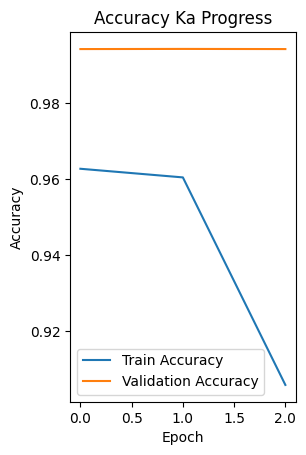

In [ ]:
# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Ka Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

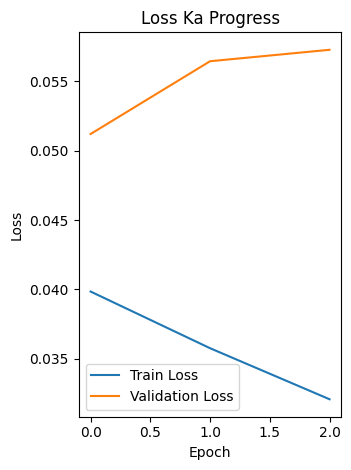

In [ ]:
# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Ka Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

**Model Evaluation**

In [ ]:
print("\nTest Data Par Evaluation")
# Final evaluation
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")


Test Data Par Evaluation
Final Test Loss: 0.0506
Final Test Accuracy: 0.9941


In [ ]:
# Predictions banaya
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Threshold 0.5 par

998/998 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step


In [ ]:
print("\nTest Data Par Evaluation ")

# Har label ke liye classification report
print("\n Har Label Ka Performance Report : ")
for i, label in enumerate(toxic_labels):
    print(f"\n** {label.upper()} **")
    print(classification_report(y_test[:,i], y_pred_binary[:,i]))


Test Data Par Evaluation 

 Har Label Ka Performance Report : 

** TOXIC **
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     28859
           1       0.81      0.77      0.79      3056

    accuracy                           0.96     31915
   macro avg       0.89      0.88      0.88     31915
weighted avg       0.96      0.96      0.96     31915


** SEVERE_TOXIC **
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31594
           1       0.47      0.26      0.33       321

    accuracy                           0.99     31915
   macro avg       0.73      0.63      0.66     31915
weighted avg       0.99      0.99      0.99     31915


** OBSCENE **
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     30200
           1       0.85      0.75      0.80      1715

    accuracy                           0.98     31915
   macro avg    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
print("y_test shape:", y_test.shape)  # (samples, 6) hona chahiye
print("y_pred shape:", y_pred_binary.shape)  # (samples, 6) hona chahiye

y_test shape: (31915, 6)
y_pred shape: (31915, 6)


**Real-World Testing**

In [88]:
def input_analysis():
    label_translation = {
        'toxic': 'Toxic (Zehrila)',
        'severe_toxic': 'Severe Toxic (Khatarnak)',
        'obscene': 'Obscene (Ashleel)',
        'threat': 'Threat (Dhamki)',
        'insult': 'Insult (Apmaan)',
        'identity_hate': 'Identity Hate (Pehchan wali Nafrat)'
    }

    while True:
        user_comment = input("\nEnter Comment karo : ")

        if user_comment.lower() == 'exit':
            print("Program is stoping ")
            break

        # Text cleaning or processing
        cleaned_comment = clean_text(user_comment)
        sequence = tokenizer.texts_to_sequences([cleaned_comment])
        padded_sequence = pad_sequences(sequence, maxlen=max_length)

        # Prediction
        predictions = model.predict(padded_sequence, verbose=0)[0]

        # Results display
        print("\nरिस्क विश्लेषण (Risk Analysis):")
        for label, score in zip(toxic_labels, predictions):
            translated_label = label_translation[label]

            # Risk level determination
            if score > 0.75:
                status = " Toxic hai"
            elif score > 0.45:
                status = " Thoda per toixic hai"
            else:
                status = " Surakshit Means Safe Hai"

            print(f"{translated_label:<30}: {score*100:.1f}% | {status}")

        # Final warning logic
        if any(score > 0.6 for score in predictions):
            print(" Warning: Toxic comment detect hua!")

# Function call
input_analysis()


Enter Comment karo : Uday is good boy

रिस्क विश्लेषण (Risk Analysis):
Toxic (Zehrila)               : 4.3% |  Surakshit Means Safe Hai
Severe Toxic (Khatarnak)      : 0.0% |  Surakshit Means Safe Hai
Obscene (Ashleel)             : 0.5% |  Surakshit Means Safe Hai
Threat (Dhamki)               : 0.1% |  Surakshit Means Safe Hai
Insult (Apmaan)               : 0.5% |  Surakshit Means Safe Hai
Identity Hate (Pehchan wali Nafrat): 0.2% |  Surakshit Means Safe Hai

Enter Comment karo : Tanmay is a motherfucker

रिस्क विश्लेषण (Risk Analysis):
Toxic (Zehrila)               : 98.6% |  Toxic hai
Severe Toxic (Khatarnak)      : 20.1% |  Surakshit Means Safe Hai
Obscene (Ashleel)             : 95.9% |  Toxic hai
Threat (Dhamki)               : 2.6% |  Surakshit Means Safe Hai
Insult (Apmaan)               : 83.9% |  Toxic hai
Identity Hate (Pehchan wali Nafrat): 11.2% |  Surakshit Means Safe Hai

Enter Comment karo : exit
Program is stoping 
